# Volume 3: GMM
    <Name>
    <Class>
    <Date>

In [1]:
import numpy as np
from scipy import stats as st
from scipy.special import logsumexp
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt
import itertools
import time
import random

from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# Problems 1-7

As described in the pdf, write the functions for initialization, calculating the logpdf both for a component and the entire GMM, drawing a sample from the GMM, performing the E and M step of the EM algorithm respectively, Using the previous methods to write a fit method for training and a predict method for clustering.

In [2]:
class GMM:
    # Problem 1
    def __init__(self, n_components, weights=None, means=None, covars=None):
        """
        Initializes a GMM.
        
        The parameters weights, means, and covars are optional. If fit() is called,
        they will be automatically initialized from the data.
        
        If specified, the parameters should have the following shapes, where d is
        the dimension of the GMM:
            weights: (n_components,)
            means: (n_components, d)
            covars: (n_components, d, d)
        """
        # assign parameters
        self.n_components = n_components
        self.weights = weights
        self.means = means
        self.covars = covars
    
    # Problem 2
    def component_logpdf(self, k, z):
        """
        Returns the logarithm of the component pdf. This is used in several computations
        in other functions.
        
        Parameters:
            k (int) - the index of the component
            z ((d,) or (..., d) ndarray) - the point or points at which to compute the pdf
        Returns:
            (float or ndarray) - the value of the log pdf of the component at 
        """
        return np.log(self.weights[k]) + st.multivariate_normal.logpdf(z,self.means[k], self.covars[k])        
    
    # Problem 2
    def pdf(self, z):
        """
        Returns the probability density of the GMM at the given point or points.
        
        Parameters:
            z ((d,) or (..., d) ndarray) - the point or points at which to compute the pdf
        Returns:
            (float or ndarray) - the value of the GMM pdf at z
        """
        # initialize
        pdf = 0
        # compute the pdf
        for i in range(self.n_components):
            pdf += self.weights[i] *  st.multivariate_normal.pdf(z,self.means[i], self.covars[i])
        return pdf
    
    # Problem 3
    def draw(self, n):
        """
        Draws n points from the GMM.
        
        Parameters:
            n (int) - the number of points to draw
        Returns:
            ((n,d) ndarray) - the drawn points, where d is the dimension of the GMM.
        """
        # initialize
        draws = []
        for _ in range(n):
            # get draws
            random_number = random.randint(0, self.n_components - 1)
            draw = mvn_dist = st.multivariate_normal(mean= self.means[random_number], cov= self.covars[random_number]).rvs()
            draws.append(draw)

        return np.array(draws)
    
    # Problem 4
    def _compute_e_step(self, Z):
        """
        Computes the values of q_i^t(k) for the given data and current parameters.
        
        Parameters:
            Z ((n, d) ndarray): the data that is being used for training; d is the
                    dimension of the data.
        Returns:
            ((n_components, n) ndarray): an array of the computed q_i^t(k) values, such
                    that result[k,i] = q_i^t(k).
        """
         # find max over component_logpdf for each data point
        logpdf = np.zeros((self.n_components, len(Z)))
        for k in range(self.n_components):
            logpdf[k] = self.component_logpdf(k, Z)

        # find max and offset each component_logpdf by max
        max_logpdf = np.max(logpdf, axis=0)
        logpdf -= max_logpdf

        # compute q_i^t(k) for each data point
        q = np.exp(logpdf - logsumexp(logpdf, axis=0))

        return q
    
    # Problem 5
    def _compute_m_step(self, Z):
        """
        Takes a step of the expectation maximization (EM) algorithm. Return
        the updated parameters.
        
        Parameters:
            Z (n,d) ndarray): the data that is being used for training; d is the
                    dimension of the data.
        Returns:
            ((n_components,) ndarray): the updated component weights
            ((n_components,d) ndarray): the updated component means
            ((n_components,d,d) ndarray): the updated component covariance matrices
        """        
        # Shape: (K,n)
        q_values = self._compute_e_step(Z)
        q_sum = np.sum(q_values, axis=1)
        
        # New weights
        weights = q_sum / len(Z)
        
        # Compute the new means
        new_means = (q_values@Z) / q_sum.reshape(-1, 1)

        # Compute the new covariances
        obs_centered = np.expand_dims(Z,0) - np.expand_dims(new_means, 1)
        new_covars = np.einsum('Kn,Knd,KnD->KdD', q_values, obs_centered, obs_centered) / np.sum(q_values, axis=1).reshape(-1,1,1)

        return weights, new_means, new_covars
        
    # Problem 6
    def fit(self, Z, tol=1e-3, maxiter=200):
        """
        Fits the model by applying the Expectation Maximization algorithm until the
        parameters appear to converge.
        
        Parameters:
            Z ((n,d) ndarray): the data to use for training; d is the
                dimension of the data.
            tol (float): the tolderance to check for convergence
            maxiter (int): the maximum number of iterations allowed
        Returns:
            self
        """
        change = np.inf

        # initialize parameters by randomly choosing points
        if self.weights is None:
            self.weights = np.ones(self.n_components) / self.n_components

        if self.means is None:
            self.means = Z[np.random.choice(len(Z), self.n_components)]

        if self.covars is None:
            self.covars = np.array([np.eye(Z.shape[1])] * self.n_components)
        
        # initialize i to 0
        i = 0
        while change > tol and i < maxiter:
            # calculate updated parameters
            weights, means, covars = self._compute_m_step(Z)

            # check for convergence
            change = np.max(np.abs(weights - self.weights)) + np.max(
                np.abs(means - self.means)) + np.max(np.abs(covars - self.covars))

            # update the parameters
            self.weights = weights
            self.means = means
            self.covars = covars
            i += 1

        return self
            
    # Problem 7
    def predict(self, Z):
        """
        Predicts the labels of data points using the trained component parameters.
        
        Parameters:
            Z ((m,d) ndarray): the data to label; d is the dimension of the data.
        Returns:
            ((m,) ndarray): the predicted labels of the data
        """
        return np.argmax([np.exp(self.component_logpdf(k, Z)) for k in range(self.n_components)], axis=0)

    def fit_predict(self, Z, tol=1e-3, maxiter=200):
        """
        Fits the model and predicts cluster labels.
        
        Parameters:
            Z ((m,d) ndarray): the data to use for training; d is the
                dimension of the data.
            tol (float): the tolderance to check for convergence
            maxiter (int): the maximum number of iterations allowed
        Returns:
            ((m,) ndarray): the predicted labels of the data
        """
        return self.fit(Z, tol, maxiter).predict(Z)

# Check Section

In [3]:
# this is used for the majority of the tests and is provided for your convenience.
def init_gmm():
    gmm = GMM(n_components = 2,
        weights = np.array([0.6, 0.4]),
        means = np.array([[-0.5, -4.0], [0.5, 0.5]]),
        covars = np.array([
        [[1, 0],[0, 1]],
        [[0.25, -1],[-1, 8]],
        ]))
    
    return gmm

### Check for Problem2 
An example of writing a check function. Alternatively an np.allclose can be used as long as
it is obvious that they are comparing the correct things.

In [4]:
def check_problem2():
    gmm = init_gmm()
    
    print(f"For input [1,-3.5] the pdf output should be: 0.0577912539363083.\n\tMine gives {gmm.pdf(np.array([1.0, -3.5]))}")
    print(f"For input [1,-3.5] the log_component output for k = 0 should be: -3.598702690175336.\n\tMine gives {gmm.component_logpdf(0,np.array([1.0, -3.5]))}")
    print(f"For input [1,-3.5] the log_component output for k = 1 should be: -3.7541677982835004.\n\tMine gives {gmm.component_logpdf(1,np.array([1.0, -3.5]))}")
    
check_problem2()

For input [1,-3.5] the pdf output should be: 0.0577912539363083.
	Mine gives 0.050779125393630824
For input [1,-3.5] the log_component output for k = 0 should be: -3.598702690175336.
	Mine gives -3.598702690175336
For input [1,-3.5] the log_component output for k = 1 should be: -3.7541677982835004.
	Mine gives -3.7541677982835004


### Check for problem 3 
Your results should look "good"

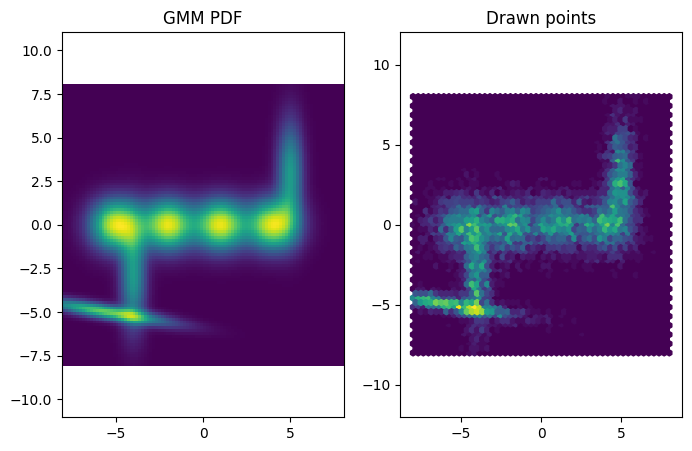

In [5]:
def check_problem3():
    """
    Draw a sample of 10,000 points from the GMM defined in the lab pdf. Plot a heatmap
    of the pdf of the GMM (using plt.pcolormesh) and a hexbin plot of the drawn points.
    How do the plots compare?
    """
    # Define the GMM
    gmm = GMM(n_components = 7,
        weights = np.array([0.175, 0.175,0.175,.175,.1,.1,.1]),
        means = np.array([[-5, 0], [-2, 0],[1, 0],[4, 0],[-4,-3],[5,3],[-5.5,-5]]),   # [-4,-2],[-5,-5]
        covars = np.array([
            [[1, 0],[0, 1]],
            [[1, 0],[0, 1]],
            [[1, 0],[0, 1]],
            [[1, 0],[0, 1]],
            [[0.25, 0],[0, 4]],
            [[0.25, 0],[0, 4]],
            [[6, -1],[-1, .25]]#[[2, -20],[0, .25]]#[[0.25, -1],[-1, 8]],[[.25,-2],[-1,2]]
        ]))
        
    points = gmm.draw(10_000)
    
    plt.figure(figsize=(8,5))
    # PDF
    x = np.linspace(-8,8,100)
    y = np.linspace(-8,8,100)
    X, Y = np.meshgrid(x, y)
    Z = gmm.pdf(np.dstack((X, Y)))
    
    plt.subplot(1,2,1)
    plt.pcolormesh(X, Y, Z)
    plt.axis('equal')
    plt.title("GMM PDF")
    
    # Hexbin
    plt.subplot(1,2,2)
    plt.hexbin(points[:,0], points[:,1], extent=(-8,8,-8,8), gridsize=50)
    plt.axis('equal')
    plt.title("Drawn points")
    
    plt.show()
    
check_problem3()

### Check for problem 4

In [10]:
def check_problem4():
    gmm = init_gmm()

    data = np.array([
        [0.5, 1.0],
        [1.0, 0.5],
        [-2.0, 0.7]
        ])
    
    correct = np.array([[3.49810771e-06, 5.30334386e-05, 9.99997070e-01],
                     [9.99996502e-01, 9.99946967e-01, 2.93011749e-06]])
    # WRITE YOUR TESTS HERE
    print(gmm._compute_e_step(data))
    print(correct)
    
check_problem4()

[[3.49810771e-06 5.30334386e-05 9.99997070e-01]
 [9.99996502e-01 9.99946967e-01 2.93011749e-06]]
[[3.49810771e-06 5.30334386e-05 9.99997070e-01]
 [9.99996502e-01 9.99946967e-01 2.93011749e-06]]


### Check for problem 5

In [9]:
def check_problem5():
    gmm = init_gmm()

    data = np.array([
        [0.5, 1.0],
        [1.0, 0.5],
        [-2.0, 0.7]
        ])
    
    cor_w,cor_mus,cor_sigs = (np.array([0.3333512, 0.6666488]),
                              np.array([[-1.99983216, 0.69999044],[ 0.74998978, 0.75000612]]),
                              np.array([[[ 4.99109197e-04, -2.91933135e-05], 
                                         [-2.91933135e-05, 2.43594533e-06]],
                                        [[ 6.25109881e-02, -6.24997069e-02], 
                                         [-6.24997069e-02, 6.24999121e-02]]]))
    # WRITE YOUR TESTS HERE
    print(gmm._compute_m_step(data))
    print(cor_w,cor_mus,cor_sigs)

check_problem5()

(array([0.3333512, 0.6666488]), array([[-1.99983216,  0.69999044],
       [ 0.74998978,  0.75000612]]), array([[[ 4.99109197e-04, -2.91933135e-05],
        [-2.91933135e-05,  2.43594533e-06]],

       [[ 6.25109881e-02, -6.24997069e-02],
        [-6.24997069e-02,  6.24999121e-02]]]))
[0.3333512 0.6666488] [[-1.99983216  0.69999044]
 [ 0.74998978  0.75000612]] [[[ 4.99109197e-04 -2.91933135e-05]
  [-2.91933135e-05  2.43594533e-06]]

 [[ 6.25109881e-02 -6.24997069e-02]
  [-6.24997069e-02  6.24999121e-02]]]


### Check for problem 6
Initialize a GMM object in the indicated position and fit the data loaded from the .npy file, then run the cell to see a beloved Disney character

Time to train: 3.2331205639999325


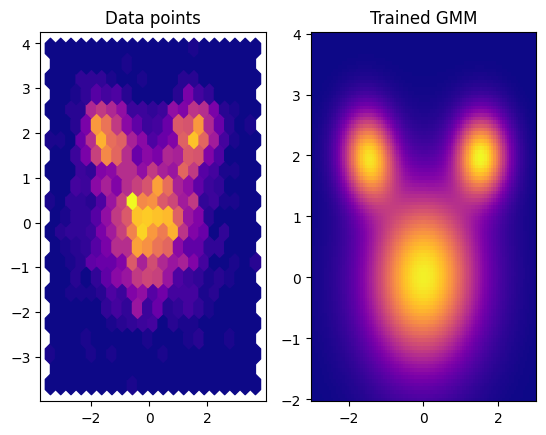

In [11]:
def check_problem6(filename='gmm_data.npy'):
    """
    The file problem6.npy contains a collection of data drawn from a GMM.
    Train a GMM on this data with n_components=3. Plot the pdf of your
    trained GMM, as well as a hexbin plot of the data.
    """
    data = np.load(filename)
    
    start = time.perf_counter()
    # my code
    gmm = GMM(n_components=3)
    gmm.fit(data)
    points = gmm.draw(10000)
    end = time.perf_counter()

    
    # Plot the pdf and a hexbin
    x = np.linspace(-3,3,100)
    y = np.linspace(-2,4,100)
    X,Y = np.meshgrid(x,y)
    XY = np.dstack((X,Y))
    
    # Plot the data points
    plt.subplot(1,2,1)
    plt.hexbin(data[:,0], data[:,1], gridsize=20, cmap='plasma')
    plt.title("Data points")
    
    plt.subplot(1,2,2)
    plt.pcolormesh(X, Y, gmm.pdf(XY), shading='auto', cmap='plasma')
    plt.title("Trained GMM")
    
    print(f"Time to train: {end-start}")
    plt.show()
    
check_problem6()

# Problem 7

In [12]:
def get_accuracy(pred_y, true_y):
    """
    Helper function to calculate the actually clustering accuracy, accounting for
    the possibility that labels are permuted.
    
    This computes the confusion matrix and uses scipy's implementation of the Hungarian
    Algorithm (linear_sum_assignment) to find the best combination, which is generally
    much faster than directly checking the permutations.
    """
    # Compute confusion matrix
    cm = confusion_matrix(pred_y, true_y)
    # Find the arrangement that maximizes the score
    r_ind, c_ind = linear_sum_assignment(cm, maximize=True)
    return np.sum(cm[r_ind, c_ind]) / np.sum(cm)
    
def problem7(filename='classification.npz'):
    """
    The file classification.npz contains a set of 3-dimensional data points "X" and 
    their labels "y". Use your class with n_components=4 to cluster the data.
    Plot the points with the predicted and actual labels, and compute and return
    your model's accuracy. Be sure to check for permuted labels.
    
    Returns:
        (float) - the GMM's accuracy on the dataset
    """
    data = np.load(filename)
    X, true_y = data['X'], data['y']
    
    # build model, fit, & predict
    gmm = GMM(4)
    gmm.fit(X)
    pred_y = gmm.predict(X)

    return get_accuracy(pred_y, true_y)

In [13]:
def method_comparison(filename='classification.npz'):
    """
    Again using classification.npz, compare your class, sklearn's GMM implementation, 
    and sklearn's K-means implementation for speed of training and for accuracy of 
    the resulting clusters. Print your results. Be sure to check for permuted labels.
    """
    # Load the data
    data = np.load(filename)
    X, true_y = data['X'], data['y']
    
    # Our class
    start = time.perf_counter()
    gmm = GMM(n_components=4).fit(X)
    end = time.perf_counter()
    gmm_pred = gmm.predict(X)
    gmm_time = end - start
    gmm_acc = get_accuracy(true_y, gmm_pred)
    
    # sklearn GMM
    start = time.perf_counter()
    sk_gmm = GaussianMixture(n_components=4).fit(X)
    end = time.perf_counter()
    sk_gmm_pred = sk_gmm.predict(X)
    sk_gmm_time = end - start
    sk_gmm_acc = get_accuracy(true_y, sk_gmm_pred)
    
    # sklearn K-means
    start = time.perf_counter()
    sk_km = KMeans(n_clusters=4).fit(X)
    end = time.perf_counter()
    sk_km_pred = sk_km.predict(X)
    sk_km_time = end - start
    sk_km_acc = get_accuracy(true_y, sk_km_pred)
    
    print("Our GMM class:")
    print(f"\tAccuracy: {gmm_acc:.4f}")
    print(f"\tTrain time: {gmm_time:.6f} s")
    
    print("sklearn GMM:")
    print(f"\tAccuracy: {sk_gmm_acc:.4f}")
    print(f"\tTrain time: {sk_gmm_time:.6f} s")
    
    print("sklearn K-means:")
    print(f"\tAccuracy: {sk_km_acc:.4f}")
    print(f"\tTrain time: {sk_km_time:.6f} s")
    
method_comparison()

Our GMM class:
	Accuracy: 0.9056
	Train time: 0.359313 s
sklearn GMM:
	Accuracy: 0.8922
	Train time: 0.130853 s
sklearn K-means:
	Accuracy: 0.7556
	Train time: 0.044093 s


/Users/brynnwoolley/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Problem 8


The following sentence may be accurate but it is not mathematically accurate, make it so:

K-means was a poor predictor compared to GMM because GMM is flexible with the boundaries it draws since it doesn't use a centroid and assigns probabiltiyies instead of labels.